### Import Modules and Obtain Datasets

In [1]:
# Plot
from matplotlib import pyplot as plt

# Read Data
import urllib
import requests
import io

# Data Manipulation
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestRegressor

In [2]:
Xtrainurl = 'https://raw.githubusercontent.com/jonahwinninghoff/Springboard_Capstone_Project/main/Assets/X_train'
Xvalidurl = 'https://raw.githubusercontent.com/jonahwinninghoff/Springboard_Capstone_Project/main/Assets/X_valid'
Xtestiurl = 'https://raw.githubusercontent.com/jonahwinninghoff/Springboard_Capstone_Project/main/Assets/X_test'

ytrainurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/y_train?raw=true'
yvalidurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/y_valid?raw=true'
ytestiurl = 'https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/y_test?raw=true'

In [3]:
# Read X_train dataset
url = urllib.request.urlopen(Xtrainurl)
file = io.BytesIO(url.read())
X_train = pd.read_csv(file, encoding='cp1252').drop('Unnamed: 0', 
                                                    axis=1)

# Read X_valid dataset
url = urllib.request.urlopen(Xvalidurl)
file = io.BytesIO(url.read())
X_valid = pd.read_csv(file, encoding='cp1252').drop('Unnamed: 0', 
                                                    axis=1)

# Read X_test dataset
url = urllib.request.urlopen(Xtestiurl)
file = io.BytesIO(url.read())
X_test = pd.read_csv(file, encoding='cp1252').drop('Unnamed: 0', 
                                                    axis=1)

In [4]:
# Read y_train dataset
response = requests.get(ytrainurl)
response.raise_for_status()
y_train = np.load(io.BytesIO(response.content))

# Read y_valid dataset
response = requests.get(yvalidurl)
response.raise_for_status()
y_valid = np.load(io.BytesIO(response.content))

# Read y_test dataset
response = requests.get(ytestiurl)
response.raise_for_status()
y_test = np.load(io.BytesIO(response.content))

### Use and Evaluate the Best Model

In [5]:
def r2_calculator(predict, true):
    merged = pd.concat([pd.DataFrame(list(predict)).rename(columns={0:'predicted'}), 
           pd.DataFrame(list(true)).rename(columns={0:'true'})],axis=1)
    
    # 1 - (predict - true)^2/(true - mean(true))^2 = 1 - RSS/TSS = r_2
    r2 = 1 - sum((merged['predicted'] - merged['true'])**2)/sum((merged['true'] - np.mean(merged['true']))**2)
    
    return r2

def adjusted_r2_calculator(predict, true):
    r2 = r2_calculator(predict, true) # r_2
    n = len(true)                     # number of rows
    k = len(X_train.columns)         # number of parameters
    
    adj_r2 = 1 - ((1-r2)*(n-1))/(n-k-1)    # 1 - [(1 - r_2)*(n - 1)/(n - k - 1)] = adjusted r^2
    
    return adj_r2

def mae_and_mse_calculator(predict, true):
    merged = pd.concat([pd.DataFrame(list(predict)).rename(columns={0:'predicted'}), 
           pd.DataFrame(list(true)).rename(columns={0:'true'})],axis=1)
    mae = sum(np.abs(merged['true'] - merged['predicted']))/len(true) # 1/n ∑ |true - predict|   = MAE
    mse = sum((merged['true'] - merged['predicted'])**2)/len(true)    # 1/n ∑ (true - predict)^2 = MSE
    
    return mae, mse

In [6]:
# Random Forest Regression
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train.ravel())

RandomForestRegressor()

In [7]:
print('Cos Similarity Validation Set')
print('R2: ' + str(round(r2_calculator(rfr_model.predict(X_valid),y_valid),4)))
print('Adjusted R2: ' + str(round(adjusted_r2_calculator(rfr_model.predict(X_valid),y_valid),4)))
print('MAE: ' + str(round(mae_and_mse_calculator(rfr_model.predict(X_valid),y_valid)[0],4)))
print('RMSE: ' + str(round(mae_and_mse_calculator(rfr_model.predict(X_valid),y_valid)[1]**0.5,4)))

Cos Similarity Validation Set
R2: 0.9091
Adjusted R2: 0.9091
MAE: 0.0687
RMSE: 0.1107


### Empirical Cumulative Distribution Function

In [8]:
# Write the ECDF function and Rescaling function using Z Score
def rescale(data):
    u = np.mean(data)
    s = np.std(data)
    z = (data - u)/s
    return z

def ecdf(data):
    n = len(data)
    x = np.sort(rescale(data))
    y = np.arange(1,n+1)/n
    return x,y

In [9]:
# True vs Predicted Target Variable
xtrue, ytrue = ecdf(list(pd.DataFrame(y_train)[0]))
xpred, ypred = ecdf(rfr_model.predict(X_train))

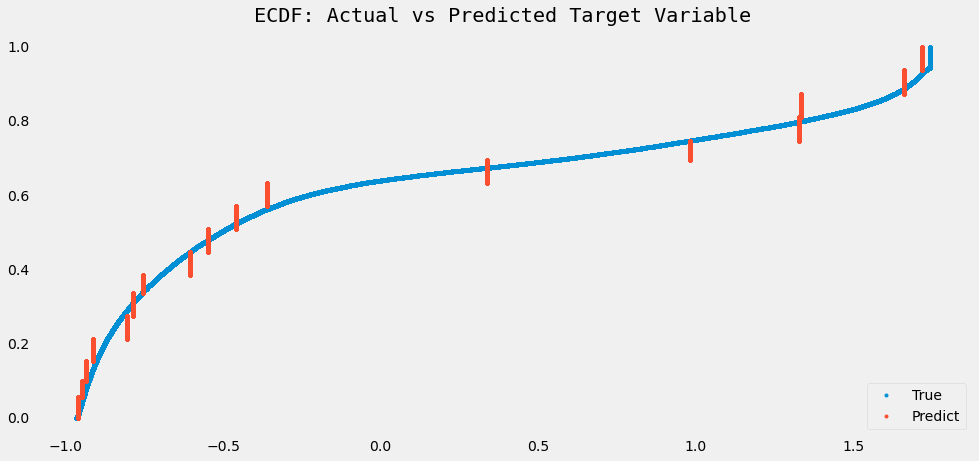

In [10]:
# Plot ECDF
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,7))
plt.plot(xtrue,ytrue,marker='.',linestyle='none',label='True')
plt.plot(xpred,ypred,marker='.',linestyle='none',label='Predict')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.title('ECDF: Actual vs Predicted Target Variable',family = 'monospace')
plt.show()

In [11]:
# ECDFize all independent variables
xcosmea, ycosmea = ecdf(X_train['cosine mean'])
xcosmed, ycosmed = ecdf(X_train['cosine median'])
xcosstd, ycosstd = ecdf(X_train['cosine std'])
xcosmin, ycosmin = ecdf(X_train['cosine minimum'])
xcosmax, ycosmax = ecdf(X_train['cosine maximum'])

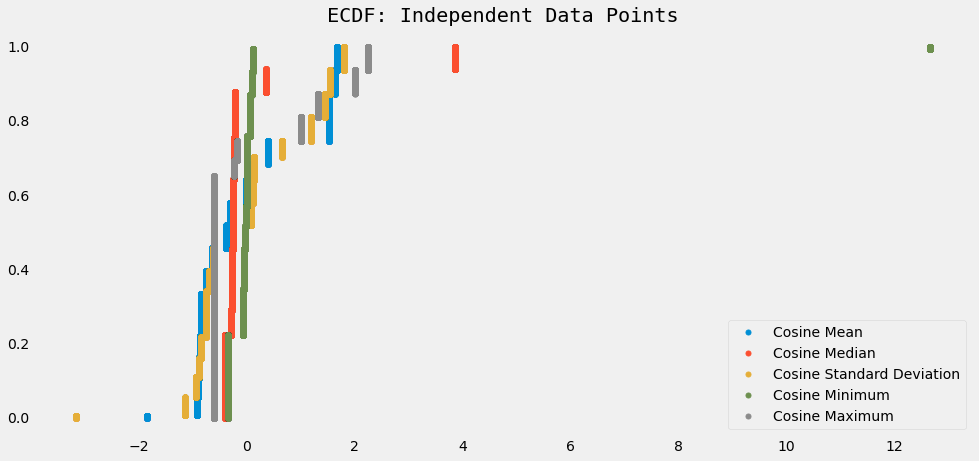

In [12]:
plt.figure(figsize=(15,7))
plt.plot(xcosmea,ycosmea,marker='.',linestyle='none',label='Cosine Mean',markersize=10)
plt.plot(xcosmed,ycosmed,marker='.',linestyle='none',label='Cosine Median',markersize=10)
plt.plot(xcosstd,ycosstd,marker='.',linestyle='none',label='Cosine Standard Deviation',markersize=10)
plt.plot(xcosmin,ycosmin,marker='.',linestyle='none',label='Cosine Minimum',markersize=10)
plt.plot(xcosmax,ycosmax,marker='.',linestyle='none',label='Cosine Maximum',markersize=10)
plt.legend(loc='lower right')
plt.grid(False)
plt.title('ECDF: Independent Data Points',family = 'monospace')
plt.show()

In [13]:
# Sum all columns for each row and ECDFize this sum column
xsum, ysum = ecdf(X_train.sum(axis=1))

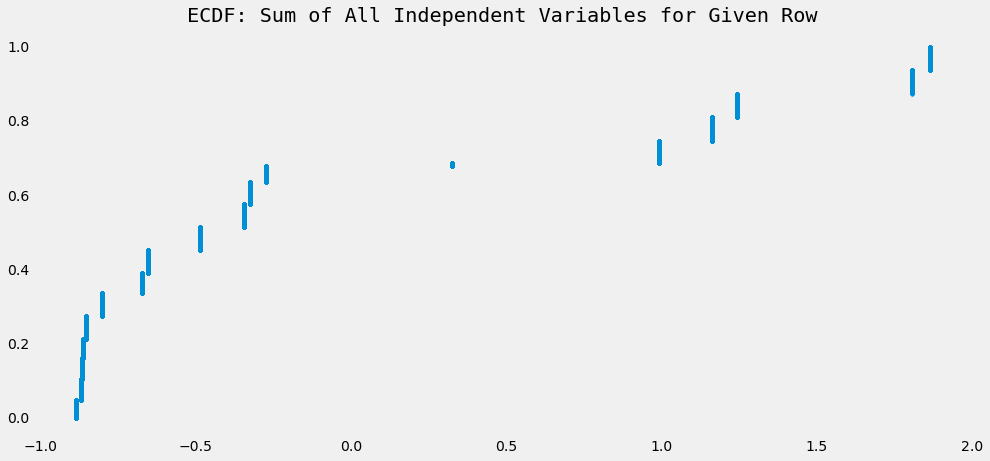

In [14]:
plt.figure(figsize=(15,7))
plt.plot(xsum,ysum,marker='.',linestyle='none')
plt.grid(False)
plt.title('ECDF: Sum of All Independent Variables for Given Row', family = 'monospace')
plt.show()